# Protein secretion

In [3]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


In [7]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

## Protein sensitivity

### Calculation

In [5]:
from ecolime.analysis import sensitivity as ss

In [8]:
complexes = [met.id for met in me.metabolites if isinstance(met,cobrame.Complex)]

In [20]:
sensitivity_df,flux_results_df = ss.sensitivity(me,complexes, NP=20,solution=1)

Calculating 850 flux responses with 20 threads
Done


In [9]:
cost_df,flux_results_cost_df = ss.biosynthetic_cost(me,complexes,cost_rxn='ATPM', NP=10, solution=1)

Calculating 850 flux responses with 10 threads
Done


In [46]:
cost_df = cost_df.rename(columns={'sensitivity':'ATPM_response'})
sensitivity_df = sensitivity_df.rename(columns={'sensitivity':'biomass_dilution_response'})

In [67]:
flux_results_df.to_csv('./results/sensitivity_raw_results.csv')
flux_results_cost_df.to_csv('./results/cost_raw_results.csv')

sensitivity_results = sensitivity_df.join(cost_df['ATPM_response'])
sensitivity_results.to_csv('./results/sensitivity_results.csv')

### Analysis

In [95]:
flux_results_df = pd.read_csv('./results/sensitivity_raw_results.csv',index_col=0)
flux_results_cost_df = pd.read_csv('./results/cost_raw_results.csv',index_col=0)
sensitivity_results = pd.read_csv('./results/sensitivity_results.csv',index_col=0)
sensitivity_results.sort_values(by='biomass_dilution_response',ascending=False)

,molecular_weight,biomass_dilution_response,ATPM_response
CPLX8J2-24,944.132256,663.970798,204474.902462
CPLX8J2-60,372.657840,472.530050,150644.527569
BSU14630-MONOMER_mod_pydx5p,535.850563,389.403880,119885.805910
CPLX8J2-54,368.486456,375.363146,118340.645894
CPLX000-65,449.351494,351.442644,108483.872175
...,...,...,...
BSU25410-MONOMER,6.712814,4.706550,1450.192056
BSU01340-MONOMER,6.511539,4.593184,1413.870534
BSU05980-MONOMER,6.066007,4.395255,1354.132308
BSU01400-MONOMER,4.316413,3.201138,986.782372


Text(0, 0.5, 'Count')

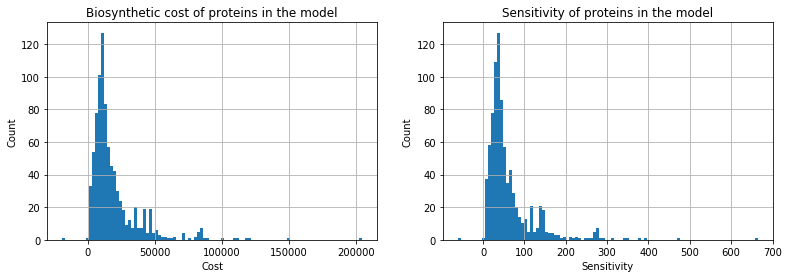

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sensitivity_results['ATPM_response'].hist(bins=100)
plt.title('Biosynthetic cost of proteins in the model')
plt.xlabel('Cost')
plt.ylabel('Count')

plt.subplot(1,2,2)
sensitivity_results['biomass_dilution_response'].hist(bins=100)
plt.title('Sensitivity of proteins in the model')
plt.xlabel('Sensitivity')
plt.ylabel('Count')

In [82]:
from sklearn.linear_model import LinearRegression

MW = sensitivity_results.dropna()['molecular_weight'].values.reshape(-1, 1)
S = sensitivity_results.dropna()['biomass_dilution_response'].dropna().values.reshape(-1, 1)
C = sensitivity_results.dropna()['ATPM_response'].dropna().values.reshape(-1, 1)
S_model = LinearRegression().fit(MW,S)
C_model = LinearRegression().fit(MW,C)
S_reg = S_model.predict(MW)
C_reg = C_model.predict(MW)

Text(0.5, 1.0, 'Correlation of S and C')

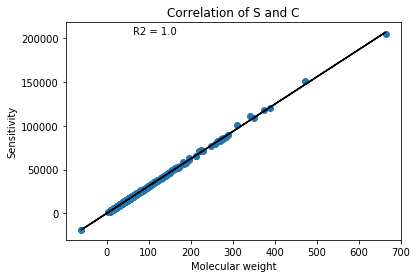

In [102]:
SC_model = LinearRegression().fit(S,C)
SC_reg = SC_model.predict(S)
plt.scatter(S,C)
plt.plot(S,SC_reg,'k')
plt.text(np.mean(S),np.max(C),'R2 = '+str(SC_model.score(S,C).round(3)))
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')
plt.title('Correlation of S and C')

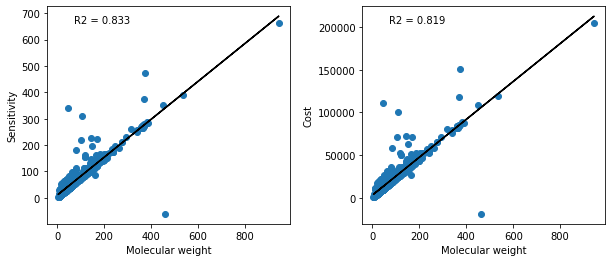

In [106]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(MW,S)
plt.plot(MW,S_reg,'k')
plt.text(np.mean(MW),np.max(S),'R2 = '+str(S_model.score(MW,S).round(3)))
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')

plt.subplot(1,2,2)
plt.scatter(MW,C)
plt.plot(MW,C_reg,'k')
plt.text(np.mean(MW),np.max(C),'R2 = '+str(C_model.score(MW,C).round(3)))
plt.xlabel('Molecular weight')
plt.ylabel('Cost')

plt.subplots_adjust(wspace=0.3)

Text(0, 0.5, 'Residuals')

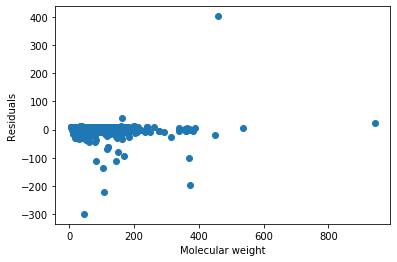

In [90]:
S_residuals = pd.DataFrame(data=S_reg-S,index=sensitivity_results.dropna().index,columns=['residuals'])
plt.scatter(MW,S_residuals.values)
plt.xlabel('Molecular weight')
plt.ylabel('Residuals')

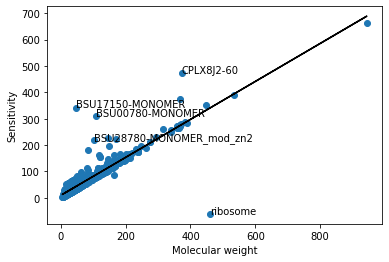

In [175]:
outliers = S_residuals.abs().sort_values(by='residuals',ascending=False).head(5).index
plt.figure()
plt.scatter(MW,S)
plt.plot(MW,S_reg,'k')
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')

for outlier_id in outliers:
    plt.text(sensitivity_results.loc[outlier_id]['molecular_weight'],
             sensitivity_results.loc[outlier_id]['biomass_dilution_response'],outlier_id)

In [110]:
for met_id in outliers.index:
    rxns = get_reactions_of_met(me,met_id,verbose=False)
    for rxn in rxns:
        if isinstance(rxn,cobrame.MetabolicReaction):
            print(met_id,rxn.subsystem)

BSU17150-MONOMER S_Carbohydrates_and_related_molecules
BSU00780-MONOMER S_Coenzymes_and_prosthetic_groups
BSU28780-MONOMER_mod_zn2 S_Carbohydrates_and_related_molecules
BSU28780-MONOMER_mod_zn2 S_Carbohydrates_and_related_molecules


In [144]:
# Look a protein up
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
genes = ['trpE','trpD','trpC','trpF','trpB']

Text(0.5, 1.0, "['trpE', 'trpD', 'trpC', 'trpF']")

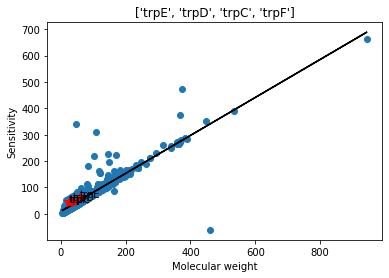

In [145]:
outliers = ['BSU11190-MONOMER']
plt.figure()
plt.scatter(MW,S)
plt.plot(MW,S_reg,'k')
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')

included_genes = []
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].iteritems():
    protein_id = locus_id+'-MONOMER'
    if protein_id not in sensitivity_results.index or sensitivity_results.loc[protein_id].isnull().any():
        continue
    x, y = sensitivity_results.loc[locus_id+'-MONOMER']['molecular_weight'],\
             sensitivity_results.loc[locus_id+'-MONOMER']['biomass_dilution_response']
    plt.plot(x,y,marker='*',markersize=10,color='red')
    plt.text(x,y,gene_name)
    included_genes.append(gene_name)
plt.title(included_genes)